# TrOCR – Getting Started with Transformer Based OCR

Optical Character Recognition (OCR) has seen several innovations over the years. Its impact on retail, healthcare, banking, and many other industries has been immense. Despite a long history and several state-of-the-art models, researchers continued to innovate. Like many other fields in deep learning, OCR also saw the importance and impact of transformer neural networks. Today, we have models like TrOCR (Transformer OCR) which truly surpass the previous techniques in terms of accuracy.

## The TrOCR Architecture

TrOCR was introduced by Li et al. in the paper TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models.

The authors suggested an approach that moved away from the traditional [CNN](https://learnopencv.com/understanding-convolutional-neural-networks-cnn/) and RNN architectures of [OCR](https://learnopencv.com/deep-learning-based-text-recognition-ocr-using-tesseract-and-opencv/). Instead, they use vision and language transformer models to construct the TrOCR architecture.

The TrOCR model is made up of two stages:
- The encoder stage consists of a pretrained vision transformer model.
- And the decoder stage consists of a pretrained language transformer model

Due to their highly efficient pretraining, transformer-based models perform extremely well on downstream tasks. For this reason, the authors chose the DeIT as the vision transformer model. For the decoder stage, they chose the RoBERTa or the UniLM model, depending on the TrOCR variant.

The following image shows the simple OCR pipeline using TrOCR.
![picture](https://learnopencv.com/wp-content/uploads/2023/08/trocr-architecture-1.png)

In the above image, the left block shows the vision transformer encoder, and the right block shows the language transformer decoder. Here is a simple breakdown of the TrOCR inference stage:
- First, we input an image to the TrOCR model, which passes through the image encoder.
- The image is broken down into patches which then pass through the multi-head attention block. The feed-forward block produces the image embeddings.
- These embeddings then go to the language transformer model.
- The decoder part of the language transformer model produces the encoded outputs.
- Finally, we decode the encoded output to obtain the text in the image

One thing to note is that the images are resized to 384×384 resolution before going to the vision transformer model. This is because the DeIT model expects the image to be of a specific size.

Of course, there are several components involved in the multi-head attention, encoder, and decoder. However, these are out of the scope of this article.

## Models in the TrOCR Family

The TrOCR family of models includes several pretrained and fine-tuned models.


### TrOCR Pretrained Models

The pretrained models in the TrOCR family are called stage 1 models. These models are trained on large scale synthetically generated data. The dataset includes hundreds of millions of images of printed text lines.

The official repository includes models of three scales from the pretraining stage. They are (in increasing number of parameters):

- TrOCR-Small-Stage1
- TrOCR-Base-Stage1
- TrOCR-Large-Stage1

Undoubtedly, the Large model performs the best but also is the slowest.

### TrOCR Fine-Tuned Models


After the pretraining stage, the models were fine-tuned on the IAM Handwritten text images and SROIE printed receipts dataset.

The IAM Handwritten dataset contains images of handwritten text. Fine-tuning this dataset makes the model recognize handwritten text better than the other models.

Similarly, the SROIE dataset consists of several thousand samples of receipt images. The models fine-tuned on this dataset perform very well in recognizing printed text.

Just like the pretraining stage models, the handwritten and printed models also include three scales each:

- TrOCR-Small-IAM
- TrOCR-Base-IAM
- TrOCR-Large-IAM
- TrOCR-Small-SROIE
- TrOCR-Base-SROIE
- TrOCR-Large-SROIE

This concludes the theory and architectural discussion of TrOCR. We will now move on to inference using TrOCR.

### Inference using TrOCR and HuggingFace


Hugging Face hosts all the TrOCR models right from the pretraining to the fine-tuning stage.

We will use two models, one handwritten fine-tuned and one printed fine-tuned to run inference experiments.

On Hugging Face, the naming of the models follows trocr-<model_scale>-<training_stage> convention.

For example, The TrOCR small model trained on the IAM Handwritten dataset is called trocr-small-handwritten.

Following this, we will use the trocr-small-printed and trocr-base-handwritten models for inference.

### Installing Requirements, Imports, and Setting Computation Device

To carry out inference using Hugging Face and TrOCR, we need to install two mandatory libraries: Hugging Face transformers, sentencepiece tokenizer.

In [1]:
!pip install -q transformers
!pip install -q -U sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.7 MB/s eta 0:00:00


Mount the Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/TensorFlow2.0/TrOCR"

Mounted at /content/drive


Import the libraries

In [3]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from tqdm.auto import tqdm
from urllib.request import urlretrieve
from zipfile import ZipFile


import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import glob

From the above, we need to download urllib and zipfile and extract the inference data.

The forward pass will either use the GPU or CPU device, depending on the availability.

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

**Helper Functions**

In [5]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

URL = r"https://www.dropbox.com/scl/fi/jz74me0vc118akmv5nuzy/images.zip?rlkey=54flzvhh9xxh45czb1c8n3fp3&dl=1"
asset_zip_path = os.path.join(path, "images.zip")
# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

Next, we have a simple function to read an image in PIL format and return it for the next processing stage.

In [6]:
def read_image(image_path):
  """
    :param image_path: String, path to the input image.


    Returns:
        image: PIL Image.
    """
  image = Image.open(image_path).convert('RGB')
  return image

The read_image() function simply expects an image path and returns it in RGB color format.

Let’s also write a helper function to carry out the OCR pipeline.

In [7]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.


    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

We need to focus on a few things here. The ocr() functions expect three parameters:

- **image**: This is the PIL image in RGB color format.
- **processor**: The Hugging Face OCR pipeline expects an OCR processor that first converts the image to an appropriate format. We will talk more about this when initializing the model.
- **model**: This is the Hugging Face OCR model, which accepts the preprocessed image and gives the encoded outputs.

Just before the return statement, you may notice the batch_decode() function of the processor. This essentially converts the encoded IDs generated by the model into output text. The skip_special_tokens=True indicates that we do not want special tokens like the end of sentences or the beginning of sentences to be a part of the output.

The final helper function that we have runs inference on new images. It combines the previous functions and shows the images in the output cell.

In [8]:
def eval_new_data(data_path=None, num_samples=4, model=None):
    image_paths = glob.glob(data_path)
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = read_image(image_path)
        text = ocr(image, processor, model)
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
        plt.show()

The eval_new_data() function accepts the path to a directory, the number of samples we want to carry inference on, and the model as the parameters.

### Inference on Printed Text

Let’s load the TrOCR processor and model for printed text.

In [9]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')
model = VisionEncoderDecoderModel.from_pretrained(
    'microsoft/trocr-small-printed'
).to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


To load the TrOCR processor, we need to use the from_pretrained module of the TrOCRProcessor class. This accepts a string path to the HuggingFace repository, which contains the specific model.

**So, what does the TrOCR Processor do?**

Remember that the TrOCR model is a neural network that cannot handle images directly. We need to process the images into the appropriate format before that. The TrOCR processor first resizes the images into 384×384 resolution. Then it converts the image into normalized tensor format, which then goes into the model for inference. We can also specify in which formats we want the tensors to be in. For instance, in our case, we convert the tensors into pt format, which indicates PyToch tensors. We can also get the tensors in TensorFlow format by providing tf in case we use the TensorFlow framework.

Similarly, we use the VisionEncoderDecoderModel class to load the pretrained model. In the above code block, we load the trocr-small-printed model and also transfer the model to the device after loading it. Next, we call the eval_new_data() function to start running inference on the images cropped from old newspapers.

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


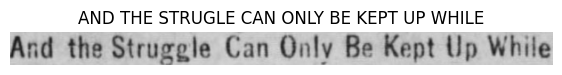

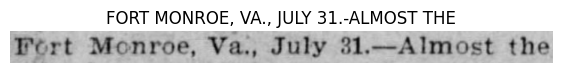

In [12]:
eval_new_data(
    data_path=os.path.join(path+'/images', 'newspaper', '*'),
    num_samples=2,
    model=model
)

The text on top of the images shows the output from the model. The model is performing extremely well even though the images are blurry and unclear. In the first image, the model can predict all the commas, full stops, and even the hyphens.

### Inference on Handwritten Text

For the handwritten text inference, we will use the base model (larger than the small model). Let’s load the handwritten TrOCR processor and model first.

In [13]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained(
    'microsoft/trocr-base-handwritten'
).to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Our approach follows that of the printed text model; we simply change the repository path to access the appropriate model.

For running inference, we need to change the data directory path.

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


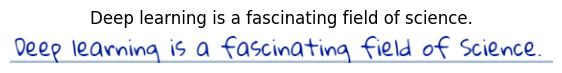

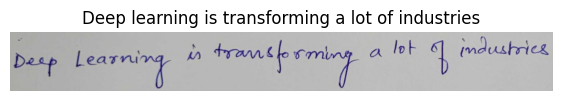

In [15]:
eval_new_data(
    data_path=os.path.join(path+'/images', 'handwritten', '*'),
    num_samples=2,
    model=model
)

Even with different types of writing styles, the model performance does not deteriorate. The combination of transformer based vision and language models shines here.

### Testing the Limits of TrOCR

Although impressive, TrOCR does not perform well on all types of images. For example, the small model struggles with images that include curved text or text from natural scenes like billboards, banners, and costumes. Following are a few examples.

![picture](https://learnopencv.com/wp-content/uploads/2023/08/trocr-curved-text-inference-1.png)

It is clear that the model is unable to understand and extract the word STATES and is predicted as > in the above image

Here is another example.

![pictute](https://learnopencv.com/wp-content/uploads/2023/08/trocr-curved-text-inference-2-1.png)

In this case, the model can predict a word but wrongly

### Improving TrOCR Performance

In the previous section, we saw that the TrOCR models may not perform well on images from the wild. The limitations arise from both the capability of the vision transformer as well as the language transformer model. There is a need for a vision transformer that has seen curved text and a language transformer that can understand the different tokens within such texts.

The best possible approach to this is fine-tuning a TrOCR model on a curved text dataset. To propose a solution for this, we will train a TrOCR model on the SCUT-CTW1500 dataset in the next article. Stay tuned!